In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix ,f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.utils.class_weight import compute_class_weight 
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

C:\Users\Ariyana-Soft\AppData\Local\Temp\ipykernel_18104\2536820871.py:7: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [2]:
from classification_utilities import display_cm, display_adj_cm
from ReadData import *
from Accuracy import accuracy, accuracy_adjacent

In [3]:
%cd ./logs
from log_well import *
%cd ../

%cd ./utilities
from normalise_logs import *
%cd ../

d:\texas_data_set\Regularize\logs
d:\texas_data_set\Regularize
d:\texas_data_set\Regularize\utilities
d:\texas_data_set\Regularize


In [4]:
well_number1, well_number2, well_number3, well_number4, well_number5, well_number6, well_number7, well_number8, well_number9, well_number10, well_number11, well_number12, WellName = ReadData()
df =  pd.concat([well_number1, well_number2, well_number3, well_number4, well_number5, well_number6, well_number7, well_number8, well_number9, well_number10])

# wells_name = ['LUKE G U', 'NOLAN', 'NOLAN', 'NEWBY', 'NEWBY']
# logs_name = ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE']

# for i in range(len(logs_name)):
#   df = normalise_logs(df,logs_name[i], wells_name[i])

df['ILD_log10'] = np.log(df['ILD_log10'])
df['ph-dph'] = df['PHIND'] - df['DeltaPHI']
df.head()

c:\Program Files\Python310\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Well Name,Facies,Formation,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,ph-dph
0,SHRIMPLIN,3,1.0,2793.0,77.45,-0.409473,9.9,11.915,4.6,1.0,1.000,2.015
1,SHRIMPLIN,3,1.0,2793.5,78.26,-0.414001,14.2,12.565,4.1,1.0,0.979,-1.635
2,SHRIMPLIN,3,1.0,2794.0,79.05,-0.418550,14.8,13.050,3.6,1.0,0.957,-1.750
3,SHRIMPLIN,3,1.0,2794.5,86.10,-0.423120,13.9,13.115,3.5,1.0,0.936,-0.785
4,SHRIMPLIN,3,1.0,2795.0,74.58,-0.435409,13.5,13.300,3.4,1.0,0.915,-0.200


In [5]:
wells = df.groupby('Well Name')

blind_df = wells.get_group("SHANKLE")
# blind_df = blind_df.drop(labels=['GR','ILD_log10','DeltaPHI','PHIND','PE'], axis=1)
# blind_df = blind_df.sort_values("Depth")

blind_df.head()

,Well Name,Facies,Formation,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,ph-dph
937,SHANKLE,2,1.0,2774.5,98.36,-0.443167,-0.1,18.685,2.9,1.0,1.000,18.785
938,SHANKLE,2,1.0,2775.0,97.57,-0.460449,7.9,16.745,3.2,1.0,0.984,8.845
939,SHANKLE,2,1.0,2775.5,98.41,-0.486133,12.8,14.105,3.2,1.0,0.968,1.305
940,SHANKLE,2,1.0,2776.0,85.92,-0.515838,13.0,13.385,3.4,1.0,0.952,0.385
941,SHANKLE,2,1.0,2776.5,83.16,-0.524249,12.3,13.345,3.4,1.0,0.935,1.045


In [6]:
train_set = df.loc[df['Well Name'] !='SHANKLE']

# train_set = train_set.drop(labels=['GR','ILD_log10','DeltaPHI','PHIND','PE'], axis=1)
# train_set = train_set.sort_values("Depth")

train_set.head()

,Well Name,Facies,Formation,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,ph-dph
0,SHRIMPLIN,3,1.0,2793.0,77.45,-0.409473,9.9,11.915,4.6,1.0,1.000,2.015
1,SHRIMPLIN,3,1.0,2793.5,78.26,-0.414001,14.2,12.565,4.1,1.0,0.979,-1.635
2,SHRIMPLIN,3,1.0,2794.0,79.05,-0.418550,14.8,13.050,3.6,1.0,0.957,-1.750
3,SHRIMPLIN,3,1.0,2794.5,86.10,-0.423120,13.9,13.115,3.5,1.0,0.936,-0.785
4,SHRIMPLIN,3,1.0,2795.0,74.58,-0.435409,13.5,13.300,3.4,1.0,0.915,-0.200


In [7]:
train_set["GR"] = np.where(train_set["GR"] > train_set['GR'].quantile(0.985),  np.nan, train_set['GR'])
blind_df["GR"] = np.where(blind_df["GR"] > blind_df['GR'].quantile(0.985),  np.nan, blind_df['GR'])

train_set["DeltaPHI"] = np.where(train_set["DeltaPHI"] < train_set['DeltaPHI'].quantile(0.001),  np.nan, train_set['DeltaPHI'])
train_set["DeltaPHI"] = np.where(train_set["DeltaPHI"] > train_set['DeltaPHI'].quantile(0.995),  np.nan, train_set['DeltaPHI'])
blind_df["DeltaPHI"] = np.where(blind_df["DeltaPHI"] < blind_df['DeltaPHI'].quantile(0.001),  np.nan, blind_df['DeltaPHI'])
blind_df["DeltaPHI"] = np.where(blind_df["DeltaPHI"] > blind_df['DeltaPHI'].quantile(0.995),  np.nan, blind_df['DeltaPHI'])

train_set["PHIND"] = np.where(train_set["PHIND"] > train_set['PHIND'].quantile(0.995),  np.nan, train_set['PHIND'])
blind_df["PHIND"] = np.where(blind_df["PHIND"] > blind_df['PHIND'].quantile(0.995), np.nan, blind_df['PHIND'])

train_set["PE"] = np.where(train_set["PE"] < train_set['PE'].quantile(0.0023),  np.nan, train_set['PE'])
train_set["PE"] = np.where(train_set["PE"] > train_set['PE'].quantile(0.998),  np.nan, train_set['PE'])
blind_df["PE"] = np.where(blind_df["PE"] < blind_df['PE'].quantile(0.0023),  np.nan, blind_df['PE'])
blind_df["PE"] = np.where(blind_df["PE"] > blind_df['PE'].quantile(0.998),  np.nan, blind_df['PE'])



C:\Users\Ariyana-Soft\AppData\Local\Temp\ipykernel_18104\10124279.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set["GR"] = np.where(train_set["GR"] > train_set['GR'].quantile(0.985),  np.nan, train_set['GR'])
C:\Users\Ariyana-Soft\AppData\Local\Temp\ipykernel_18104\10124279.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  blind_df["GR"] = np.where(blind_df["GR"] > blind_df['GR'].quantile(0.985),  np.nan, blind_df['GR'])
C:\Users\Ariyana-Soft\AppData\Local\Temp\ipykernel_18104\10124279.py:4: 

In [8]:
wells = train_set.groupby('Well Name')

In [9]:
well_number1 = wells.get_group('SHRIMPLIN')
well_number2 = wells.get_group('ALEXANDER D')
well_number3 = blind_df
well_number4 = wells.get_group('LUKE G U')
well_number5 = wells.get_group('KIMZEY A')
well_number6 = wells.get_group('CROSS H CATTLE')
well_number7 = wells.get_group('NOLAN')
well_number8 = wells.get_group('Recruit F9')
well_number9 = wells.get_group('NEWBY')
well_number10 = wells.get_group('CHURCHMAN BIBLE')
# well_number11 = wells.get_group('STUART')
# well_number12 = wells.get_group('CRAWFORD')

In [10]:
training_data = pd.concat([well_number1, well_number2, well_number4, well_number5, well_number6, well_number7, well_number8, well_number9, well_number10])
test_data = well_number3
X_test = []
training_data = training_data.drop('Well Name', axis=1)
test_data = test_data.drop('Well Name', axis=1)

from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5, weights="distance")
training_data = imputer.fit_transform(training_data)
training_data = pd.DataFrame(training_data, columns = ['Facies','Formation', 'Depth','GR','ILD_log10','DeltaPHI', 'PHIND','PE','NM_M','RELPOS', 'ph-dph'])
test_data = imputer.fit_transform(test_data)
test_data = pd.DataFrame(test_data, columns = ['Facies','Formation', 'Depth','GR','ILD_log10','DeltaPHI', 'PHIND','PE','NM_M','RELPOS',	'ph-dph'])

X_training = training_data.drop('Facies', axis=1)
Y_training = training_data['Facies']

X_test = test_data.drop('Facies', axis=1)
Y_test = test_data['Facies']
    
X_training['Depth'] = pd.to_numeric(X_training['Depth'])
X_training['Formation'] =  pd.to_numeric(X_training['Formation'])
X_training['GR'] =  pd.to_numeric(X_training['GR'])
X_training['ILD_log10'] = pd.to_numeric(X_training['ILD_log10'])
X_training['DeltaPHI'] = pd.to_numeric(X_training['DeltaPHI'])
X_training['PHIND'] =  pd.to_numeric(X_training['PHIND'])
X_training['PE'] = pd.to_numeric(X_training['PE'])
X_training['NM_M'] = pd.to_numeric(X_training['NM_M'])
X_training['RELPOS'] = pd.to_numeric(X_training['RELPOS'])
X_training['ph-dph'] = pd.to_numeric(X_training['ph-dph'])

Y_training = pd.to_numeric(Y_training)
    
X_test['Depth'] = pd.to_numeric(X_test['Depth'])
X_test['Formation'] = pd.to_numeric(X_test['Formation'])
X_test['GR'] = pd.to_numeric(X_test['GR'])
X_test['ILD_log10'] = pd.to_numeric(X_test['ILD_log10'])
X_test['DeltaPHI'] = pd.to_numeric(X_test['DeltaPHI'])
X_test['PHIND'] = pd.to_numeric(X_test['PHIND'])
X_test['PE'] = pd.to_numeric(X_test['PE'])
X_test['NM_M'] = pd.to_numeric(X_test['NM_M'])
X_test['RELPOS'] =pd.to_numeric(X_test['RELPOS'])
X_test['ph-dph'] =pd.to_numeric(X_test['ph-dph'])

Y_test = pd.to_numeric(Y_test)
    
Robust = RobustScaler().fit(X_training)
X_training = Robust.transform(X_training)
X_test = Robust.transform(X_test)

Standard = StandardScaler().fit(X_training)
X_training = Standard.transform(X_training)
X_test = Standard.transform(X_test)

MinMax = MinMaxScaler().fit(X_training)
X_training = MinMax.transform(X_training)
X_test = MinMax.transform(X_test)
    
a =  np.unique(Y_training)
weights = compute_class_weight(class_weight='balanced', classes=a, y=Y_training)

weights = dict(zip([0,1,2,3,4,5,6,7,8], weights))

In [11]:
weights

{0: 2.2967101179391682,
 1: 0.4830917874396135,
 2: 0.620077090665326,
 3: 1.5572390572390573,
 4: 1.4841556357801846,
 5: 0.8045227223309415,
 6: 3.315412186379928,
 7: 0.6363949088407292,
 8: 2.2222222222222223}

In [12]:
# for key in weights:
#     weights[key] = weights[key]/(2.2967101179391682+0.4830917874396135+0.620077090665326+1.5572390572390573+1.4841556357801846+0.8045227223309415+3.315412186379928+0.6363949088407292+2.2222222222222223)
# weights

In [13]:
Y_training = pd.get_dummies(Y_training)
Y_test = pd.get_dummies(Y_test)

In [14]:
Y_test["9"] = [0] * len(Y_test)


In [15]:
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(layers.Dense(units=hp.Choice('units_'+str(20),values=[10]), activation=hp.Choice('act_' + str(20),['relu'])))
    for i in range(hp.Int('layers', 1, 10)):
        model.add(layers.Dense(units=hp.Int('units_'+ str(i), 10, 100, step=10),
                                activation= hp.Choice('act_' + str(i), ['relu', 'sigmoid', 'elu', 'gelu'])))
 
    model.add(layers.Dense(units=hp.Choice('units_'+str(30),values=[9]), activation=hp.Choice('act_' + str(30),['softmax'])))
    model.compile(
        keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-4])),
            loss='categorical_crossentropy',
            metrics=['accuracy'])
    return model

In [16]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=5,
    directory='my_dir',
    project_name='MLP')

INFO:tensorflow:Reloading Oracle from existing project my_dir\MLP\oracle.json
INFO:tensorflow:Reloading Tuner from my_dir\MLP\tuner0.json


In [17]:
# es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10000)
# rlrop = ReduceLROnPlateau(monitor='val_accuracy', pattience=10000)
mch = ModelCheckpoint('log_noron.h5', monitor='val_accuracy', mode='max', save_best_only=True)

In [18]:
tuner.search(X_training, Y_training, epochs=100, validation_data=(X_test, Y_test), batch_size=32, callbacks=[mch],  class_weight=weights)

Trial 10 Complete [00h 03m 38s]
val_accuracy: 0.4374164819717407

Best val_accuracy So Far: 0.5567928671836853
Total elapsed time: 00h 34m 26s


INFO:tensorflow:Oracle triggered exit


In [19]:
import os
%cd ./utilities
os.startfile('Jafar_Bekhab-Fatma.mp3')
%cd ../

d:\texas_data_set\Regularize\utilities
d:\texas_data_set\Regularize


In [18]:
tuner.results_summary()

Results summary
Results in my_dir\MLP
Showing 10 best trials
Trial summary
Hyperparameters:
units_20: 10
act_20: relu
layers: 3
units_0: 50
act_0: gelu
units_30: 9
act_30: softmax
learning_rate: 0.01
units_1: 50
act_1: sigmoid
units_2: 50
act_2: elu
units_3: 50
act_3: relu
units_4: 90
act_4: elu
units_5: 40
act_5: relu
Score: 0.5567928671836853
Trial summary
Hyperparameters:
units_20: 10
act_20: relu
layers: 8
units_0: 100
act_0: gelu
units_30: 9
act_30: softmax
learning_rate: 0.0001
units_1: 60
act_1: relu
units_2: 60
act_2: sigmoid
units_3: 40
act_3: elu
units_4: 20
act_4: relu
units_5: 60
act_5: gelu
units_6: 20
act_6: relu
units_7: 70
act_7: elu
units_8: 30
act_8: relu
Score: 0.5233853101730347
Trial summary
Hyperparameters:
units_20: 10
act_20: relu
layers: 9
units_0: 40
act_0: gelu
units_30: 9
act_30: softmax
learning_rate: 0.0001
units_1: 30
act_1: gelu
units_2: 100
act_2: gelu
units_3: 20
act_3: gelu
units_4: 80
act_4: sigmoid
units_5: 10
act_5: elu
units_6: 20
act_6: relu
unit

In [17]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, activation='relu' ,input_shape=(10,)),
    tf.keras.layers.Dense(40, activation='gelu'),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(40, activation='sigmoid'),
    tf.keras.layers.Dense(20, activation='elu'),
    tf.keras.layers.Dense(90, activation='relu'),
    tf.keras.layers.Dense(70, activation='gelu'),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(80, activation='elu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(9, activation='softmax')
])
model.compile( keras.optimizers.Adam(learning_rate= 0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
mch = ModelCheckpoint('log_noron_1.h5', monitor='val_accuracy', mode='max', save_best_only=True)

In [19]:
history = model.fit(X_training, Y_training, epochs=100, validation_data=(X_test, Y_test), batch_size=32, callbacks=[mch],  class_weight=weights)

Epoch 1/100
116/116 [==============================] - 2s 10ms/step - loss: 2.1981 - accuracy: 0.1938 - val_loss: 2.1729 - val_accuracy: 0.2316
Epoch 2/100
116/116 [==============================] - 1s 5ms/step - loss: 2.1846 - accuracy: 0.2408 - val_loss: 2.1295 - val_accuracy: 0.3007
Epoch 3/100
116/116 [==============================] - 0s 3ms/step - loss: 2.0562 - accuracy: 0.2881 - val_loss: 1.6264 - val_accuracy: 0.2138
Epoch 4/100
116/116 [==============================] - 0s 3ms/step - loss: 1.7537 - accuracy: 0.2211 - val_loss: 1.4377 - val_accuracy: 0.2138
Epoch 5/100
116/116 [==============================] - 0s 3ms/step - loss: 1.6579 - accuracy: 0.2616 - val_loss: 1.3838 - val_accuracy: 0.2116
Epoch 6/100
116/116 [==============================] - 1s 5ms/step - loss: 1.6248 - accuracy: 0.2195 - val_loss: 1.3582 - val_accuracy: 0.4276
Epoch 7/100
116/116 [==============================] - 0s 3ms/step - loss: 1.6109 - accuracy: 0.2876 - val_loss: 1.3586 - val_accuracy: 0.385

In [20]:
model.load_weights('log_noron_1.h5')

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 10)                110       
                                                                 
 dense_4 (Dense)             (None, 40)                440       
                                                                 
 dense_5 (Dense)             (None, 30)                1230      
                                                                 
 dense_6 (Dense)             (None, 40)                1240      
                                                                 
 dense_7 (Dense)             (None, 20)                820       
                                                                 
 dense_8 (Dense)             (None, 90)                1890      
                                                                 
 dense_9 (Dense)             (None, 70)               

In [22]:
Y_P  = model.predict(X_test)
# well_number3['Prediction'] = Y_Pred
# conf = confusion_matrix(Y_test, Y_Pred)
# display_cm(conf, Y_test)

15/15 [==============================] - 0s 1ms/step


In [23]:
Y_Pred = []
for i in range(len(Y_P)):
  Y_Pred.append(np.argmax(Y_P[i])+1)

In [24]:
# Y_Pred
Y_test = pd.DataFrame(Y_test)
Y_test = Y_test.idxmax(axis=1)
Y_test

0      2.0
1      2.0
2      2.0
3      2.0
4      2.0
      ... 
444    8.0
445    8.0
446    8.0
447    4.0
448    4.0
Length: 449, dtype: float64

In [46]:
# Y_test.idxmax(axis=1).head()

In [25]:

well_number3['Prediction'] = Y_Pred
conf = confusion_matrix(Y_test, Y_Pred)
display_cm(conf, Y_test)

           Pred      SS      CSiS      FSiS      SiSh      MS      WS      D      PS      BS Total
           True
             SS      38        51         0         0       0       0      0       0       0    89
           CSiS       6        65        18         0       0       0      0       0       0    89
           FSiS       3        26        88         0       0       0      0       0       0   117
           SiSh       0         0         0         1       0       0      5       1       0     7
             MS       0         0         0        12       0       3      4       0       0    19
             WS       0         0         1        10       0      44      7       9       0    71
              D       0         0         0         8       0       6      3       0       0    17
             PS       0         0         0         1       0      14     10      14       1    40
             BS       0         0         0         0       0       0      0       0       0 

C:\Users\Ariyana-Soft\AppData\Local\Temp\ipykernel_18104\3902197868.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  well_number3['Prediction'] = Y_Pred
d:\texas_data_set\Regularize\classification_utilities.py:15: RuntimeWarning: invalid value encountered in true_divide
  precision = np.diagonal(conf)/conf.sum(axis=0).astype('float')
d:\texas_data_set\Regularize\classification_utilities.py:16: RuntimeWarning: invalid value encountered in true_divide
  recall = np.diagonal(conf)/conf.sum(axis=1).astype('float')


In [37]:
adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7,8], [6,5]])
display_adj_cm(conf, Y_test, adjacent_facies)

           Pred      SS      CSiS      FSiS      SiSh      MS      WS      D      PS      BS Total
           True
             SS      89         0         0         0       0       0      0       0       0    89
           CSiS       0        89         0         0       0       0      0       0       0    89
           FSiS       3         0       114         0       0       0      0       0       0   117
           SiSh       0         0         0         1       0       0      5       1       0     7
             MS       0         0         0         0      15       0      4       0       0    19
             WS       0         0         1        10       0      60      0       0       0    71
              D       0         0         0         8       0       0      9       0       0    17
             PS       0         0         0         1       0       0      0      39       0    40
             BS       0         0         0         0       0       0      0       0       0 

C:\Users\Ariyana-Soft\AppData\Local\Temp\ipykernel_18104\3214205979.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7,8], [6,5]])
d:\texas_data_set\Regularize\classification_utilities.py:118: RuntimeWarning: invalid value encountered in true_divide
  precision = np.diagonal(conf)/conf.sum(axis=0).astype('float')
d:\texas_data_set\Regularize\classification_utilities.py:119: RuntimeWarning: invalid value encountered in true_divide
  recall = np.diagonal(conf)/conf.sum(axis=1).astype('float')


In [38]:
adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,5]])
conf = confusion_matrix(Y_test, Y_Pred)
print('Optimized facies classification accuracy = %.2f' % accuracy(conf))
print('Optimized adjacent facies classification accuracy = %.2f' % accuracy_adjacent(conf, adjacent_facies))

C:\Users\Ariyana-Soft\AppData\Local\Temp\ipykernel_18104\2683809987.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,5]])


ValueError: Found input variables with inconsistent numbers of samples: [449, 356]

In [28]:
well_number3['Prediction'] = Y_Pred

C:\Users\Ariyana-Soft\AppData\Local\Temp\ipykernel_18104\1182400236.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  well_number3['Prediction'] = Y_Pred


In [29]:
well_number3.head()

,Well Name,Facies,Formation,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,ph-dph,Prediction
937,SHANKLE,2,1.0,2774.5,98.36,-0.443167,-0.1,18.685,2.9,1.0,1.000,18.785,3
938,SHANKLE,2,1.0,2775.0,97.57,-0.460449,7.9,16.745,3.2,1.0,0.984,8.845,3
939,SHANKLE,2,1.0,2775.5,98.41,-0.486133,12.8,14.105,3.2,1.0,0.968,1.305,3
940,SHANKLE,2,1.0,2776.0,85.92,-0.515838,13.0,13.385,3.4,1.0,0.952,0.385,3
941,SHANKLE,2,1.0,2776.5,83.16,-0.524249,12.3,13.345,3.4,1.0,0.935,1.045,3


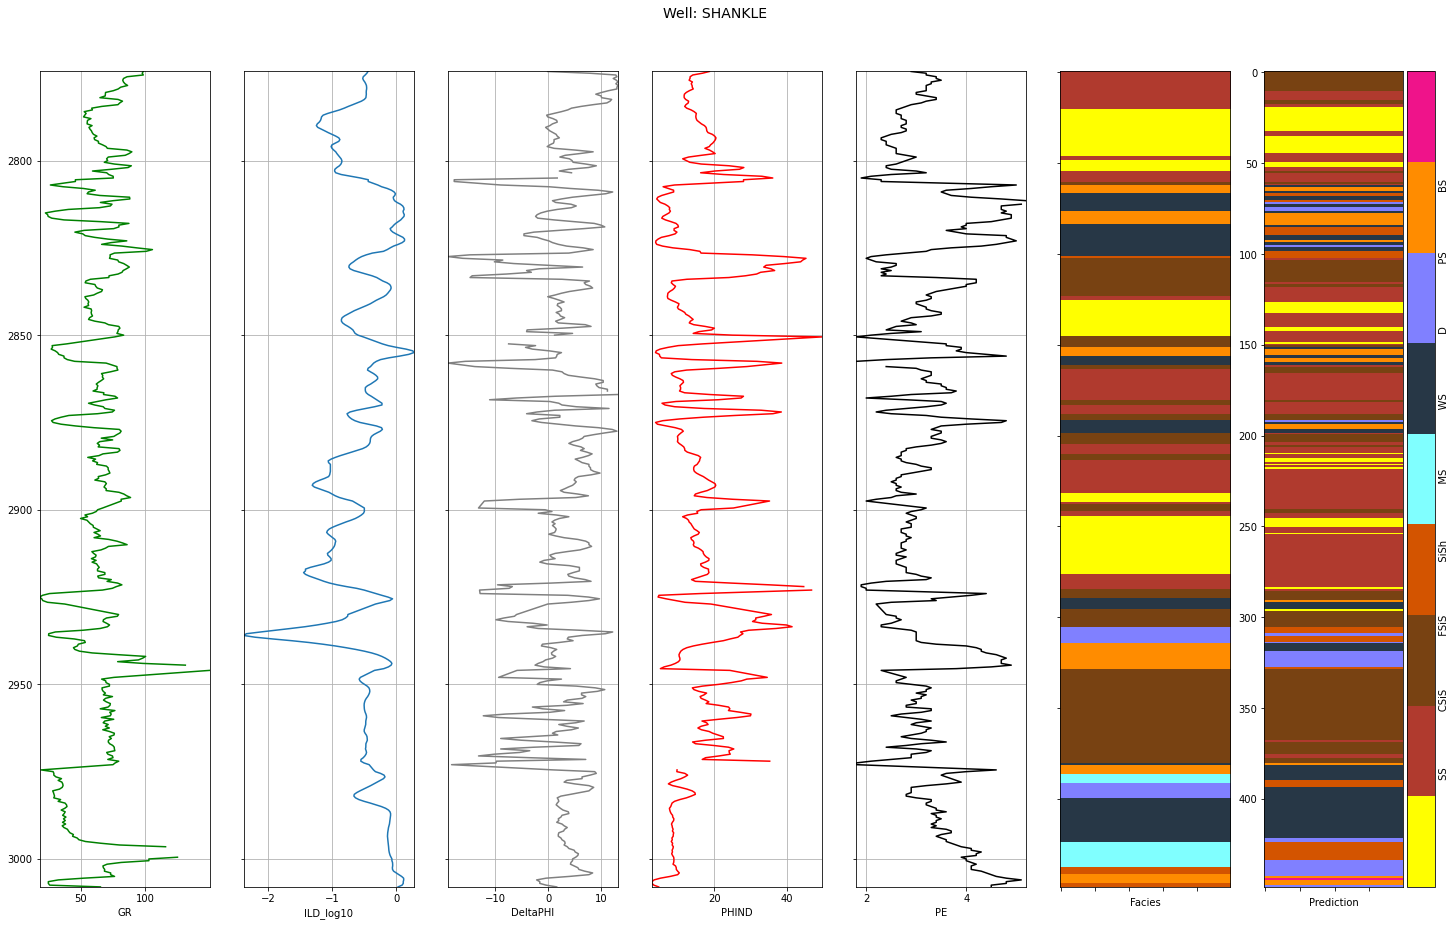

In [30]:
compare_facies_plot(well_number3, 'Prediction', test_data['Depth'].min(), test_data['Depth'].max())

15/15 [==============================] - 0s 1ms/step


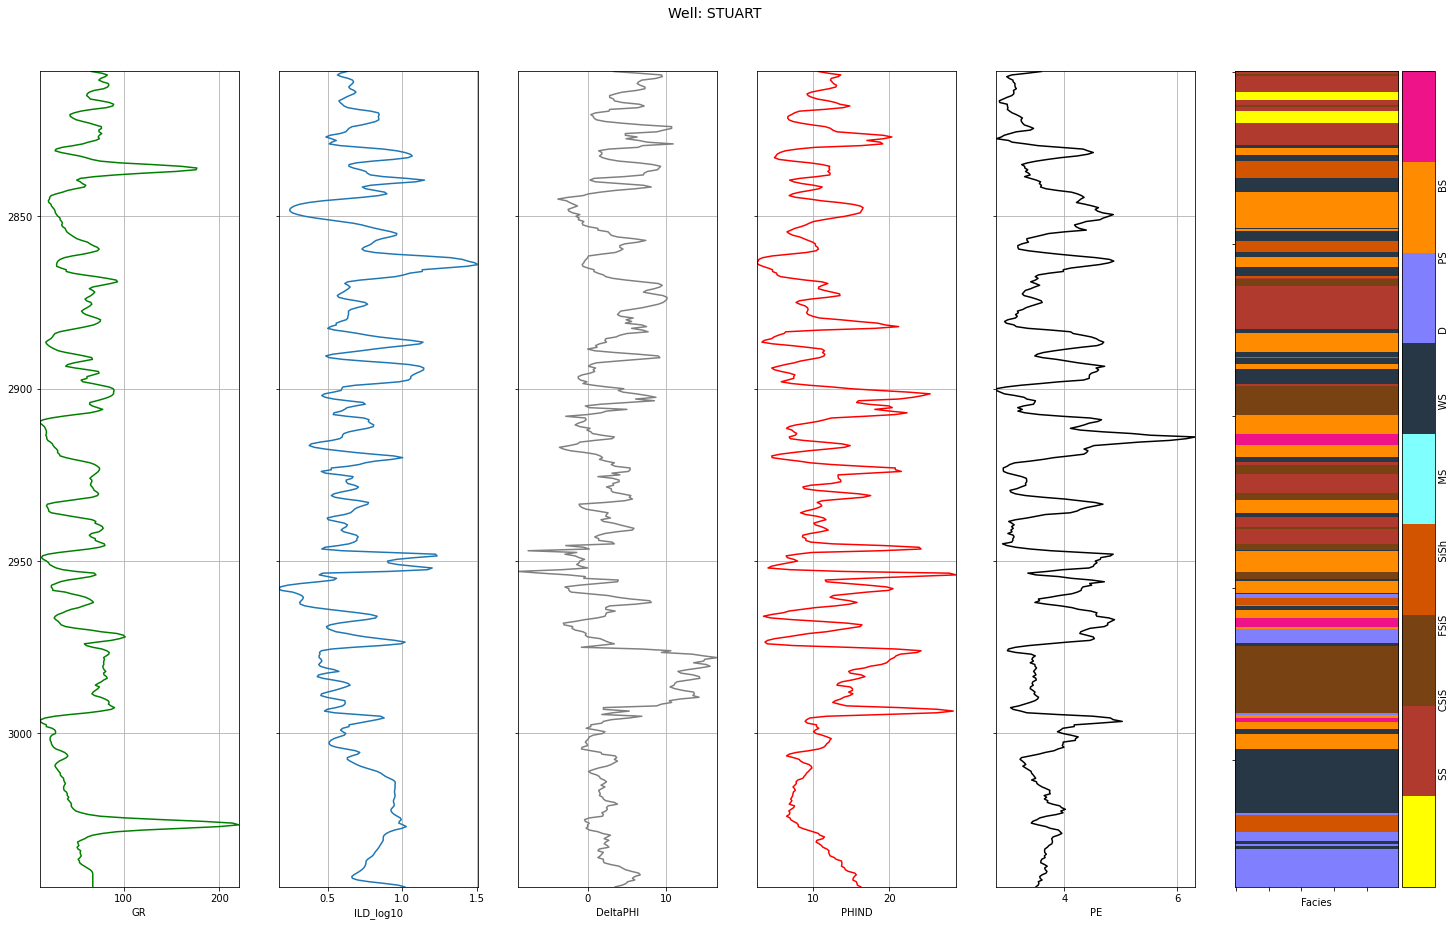

In [32]:
well_number11['ph-dph'] = well_number11['PHIND'] - well_number11['DeltaPHI']
X_well11 = Robust.transform(well_number11.drop(['Well Name', 'Facies'], axis=1))
X_well11 = Standard.transform(X_well11)
X_well11 = MinMax.transform(X_well11)

Y_P = model.predict(X_well11)

Y_Pred = []
for i in range(len(Y_P)):
  Y_Pred.append(np.argmax(Y_P[i])+1)

well_number11['Facies'] = Y_Pred
log_well(well_number11.sort_values("Depth"), well_number11['Depth'].min(), well_number11['Depth'].max())

12/12 [==============================] - 0s 1ms/step


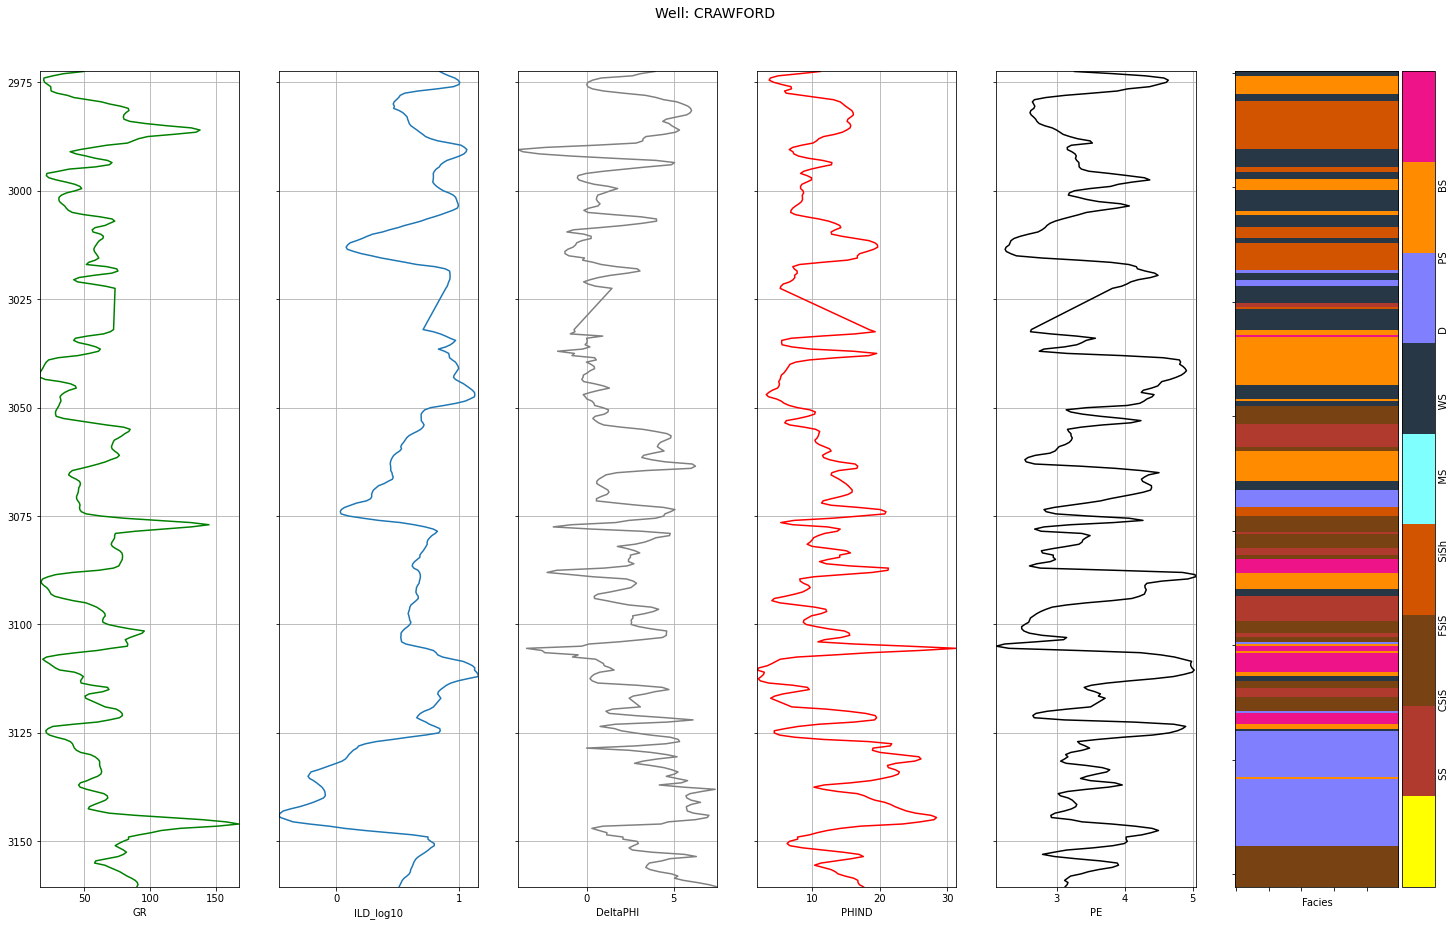

In [34]:
well_number12['ph-dph'] = well_number12['PHIND'] - well_number12['DeltaPHI']
X_well12 = Robust.transform(well_number12.drop(['Well Name', 'Facies'], axis=1))
X_well12 = Standard.transform(X_well12)
X_well12 = MinMax.transform(X_well12)

Y_P = model.predict(X_well12)

Y_Pred = []
for i in range(len(Y_P)):
  Y_Pred.append(np.argmax(Y_P[i])+1)

well_number12['Facies'] = Y_Pred
log_well(well_number12.sort_values("Depth"), well_number12['Depth'].min(), well_number12['Depth'].max())

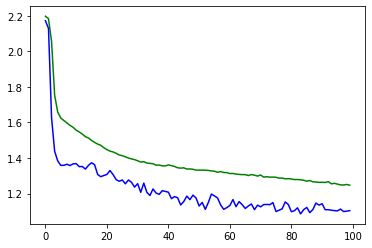

In [35]:
plt.plot(history.history['loss'], color='green', label='Train Data')
plt.plot(history.history['val_loss'], color='blue', label='Validation Data')

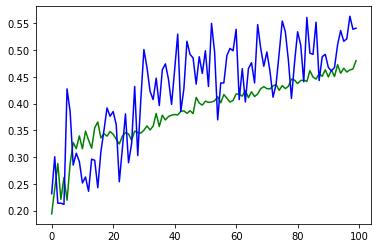

In [36]:
plt.plot(history.history['accuracy'], color='green', label='Train Data')
plt.plot(history.history['val_accuracy'], color='blue', label='Validation Data')